# Process preedited 4T1 in vitro MERFISH data

## Purpose

This notebook processes MERFISH data from a lineage tracing experiment. It calls clones based on shared target sites and identifies doublets. It also processes target site spots, filtering out dim spots, removing target sites with multiple integrations, and finally assigning a unique target site allele to each cell.

## Setup

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import geopandas as gpd
import numpy as np
from pathlib import Path
import sys
import petracer
np.random.seed(42)

from petracer.config import colors, sequential_cmap, site_names
from petracer.clones import assign_clones
site_names = list(site_names.keys())

base_path, data_path, plot_path, results_path = petracer.config.get_paths("preedited")
petracer.config.set_theme()

%load_ext autoreload
%autoreload 2

## Load data

Specify samples and names

In [5]:
samples = {"4T1_preedited":Path("/lab/weissman_imaging/4T1/240426_preedited_invitro")}

Cells

In [6]:
cells = []
for sample, path in samples.items():
    sample_cells = pd.read_csv(path / "polygons_metadata.csv")
    sample_polygons = gpd.read_file(path / "polygons_union.json").set_crs(None, allow_override=True)
    sample_cells = sample_polygons.merge(sample_cells, on="cell")
    sample_cells["sample"] = sample
    sample_cells["cellBC"] = (sample + "-" + sample_cells["cell"].astype(str).values)
    cells.append(sample_cells.drop(columns=["cell"]))
cells = pd.concat(cells, ignore_index=True)
cells.index = cells.cellBC.values
adata = ad.AnnData(obs=cells)
adata.obs["type"] = "tracing"
adata.obs["type"] = pd.Categorical(adata.obs["type"], 
       categories=["tracing", "non-tracing", "doublet", "low_detection", "low_umi", "high_mito"])
adata.obsm["spatial"] = cells[["centroid_x", "centroid_y"]].values

Target site

In [7]:
alleles = []
for sample, path in samples.items():
    sample_alleles =  pd.read_csv(f"{path}/decoded_spots.csv",keep_default_na=False,index_col=0)
    sample_alleles["sample"] = sample
    sample_alleles["cellBC"] = (sample + "-" + sample_alleles["cell"].astype(str).values)
    alleles.append(sample_alleles)
alleles = pd.concat(alleles)
alleles = alleles[alleles["cellBC"].isin(cells.cellBC)]
alleles.rename(columns={"intBC":"intID"},inplace=True)

## Imaging statistics

Cells per sample

<Axes: xlabel='sample', ylabel='count'>

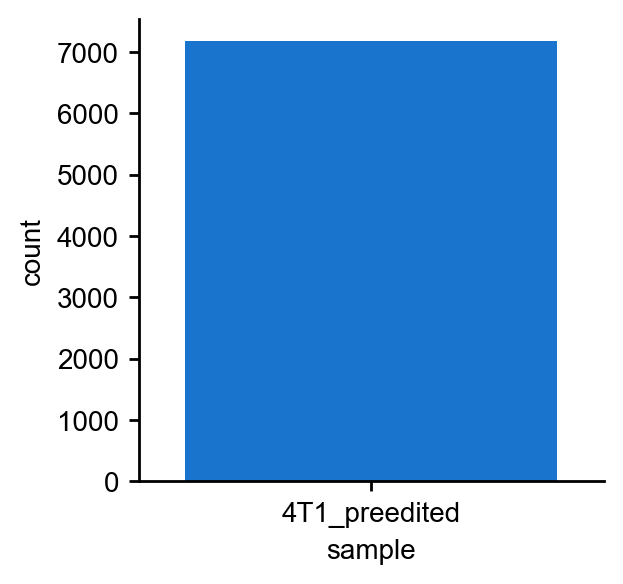

In [8]:
sns.countplot(data = adata.obs, x = "sample",hue = "sample",legend=False,saturation = 1)

intBC intensity vs distance

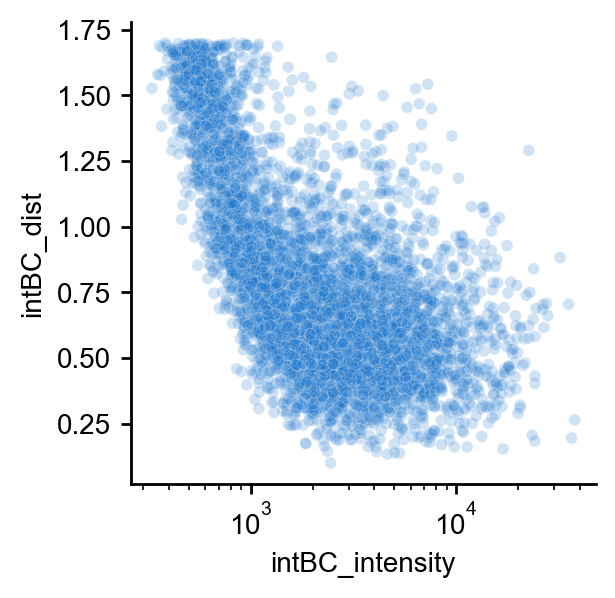

In [9]:
sns.scatterplot(data =alleles.sample(5000), x = "intBC_intensity", y = "intBC_dist",
                hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")

Alleles per cell

<Axes: xlabel='n_spots', ylabel='Count'>

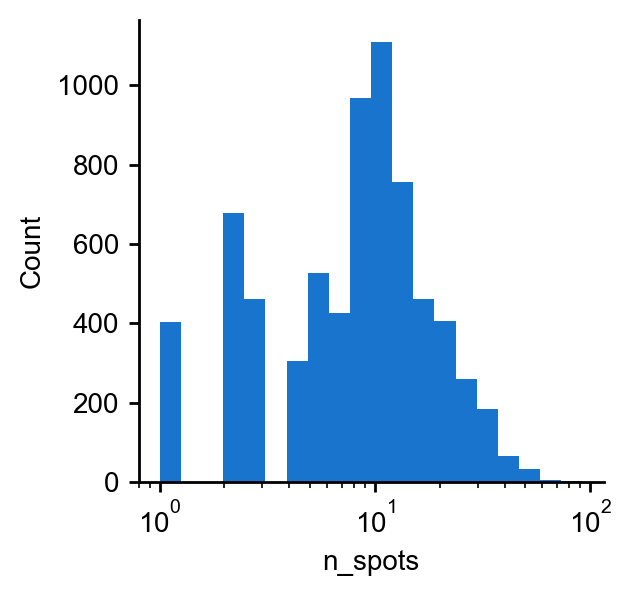

In [10]:
sns.histplot(data = alleles.groupby(["sample","cellBC"]).size().reset_index(name = "n_spots"), 
            x = "n_spots",hue = "sample",legend=False,multiple="stack",linewidth=0,bins = 20,alpha = 1,log_scale=True)

## Filter target site spots

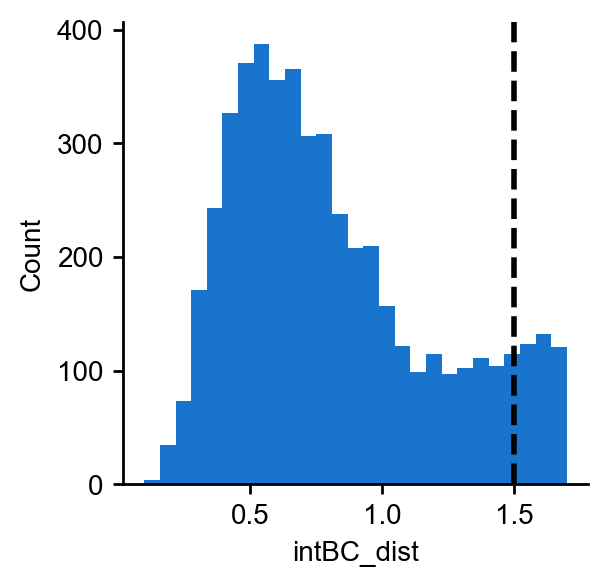

In [11]:
min_intBC_dist = 1.5
filtered_alleles = alleles.query("intBC_dist < @min_intBC_dist").copy()
sns.histplot(data =alleles.sample(5000), x = "intBC_dist",color = colors[1],linewidth = 0,alpha = 1)
plt.axvline(min_intBC_dist, linestyle="--",color = "black")

## Assign clones

Load clone whitelist

In [12]:
clone_whitelist = pd.read_csv(data_path / "preedited_clone_whitelist.csv",
                              keep_default_na=False,dtype={"clone":str})

Assign cells to clones using jaccard similarity

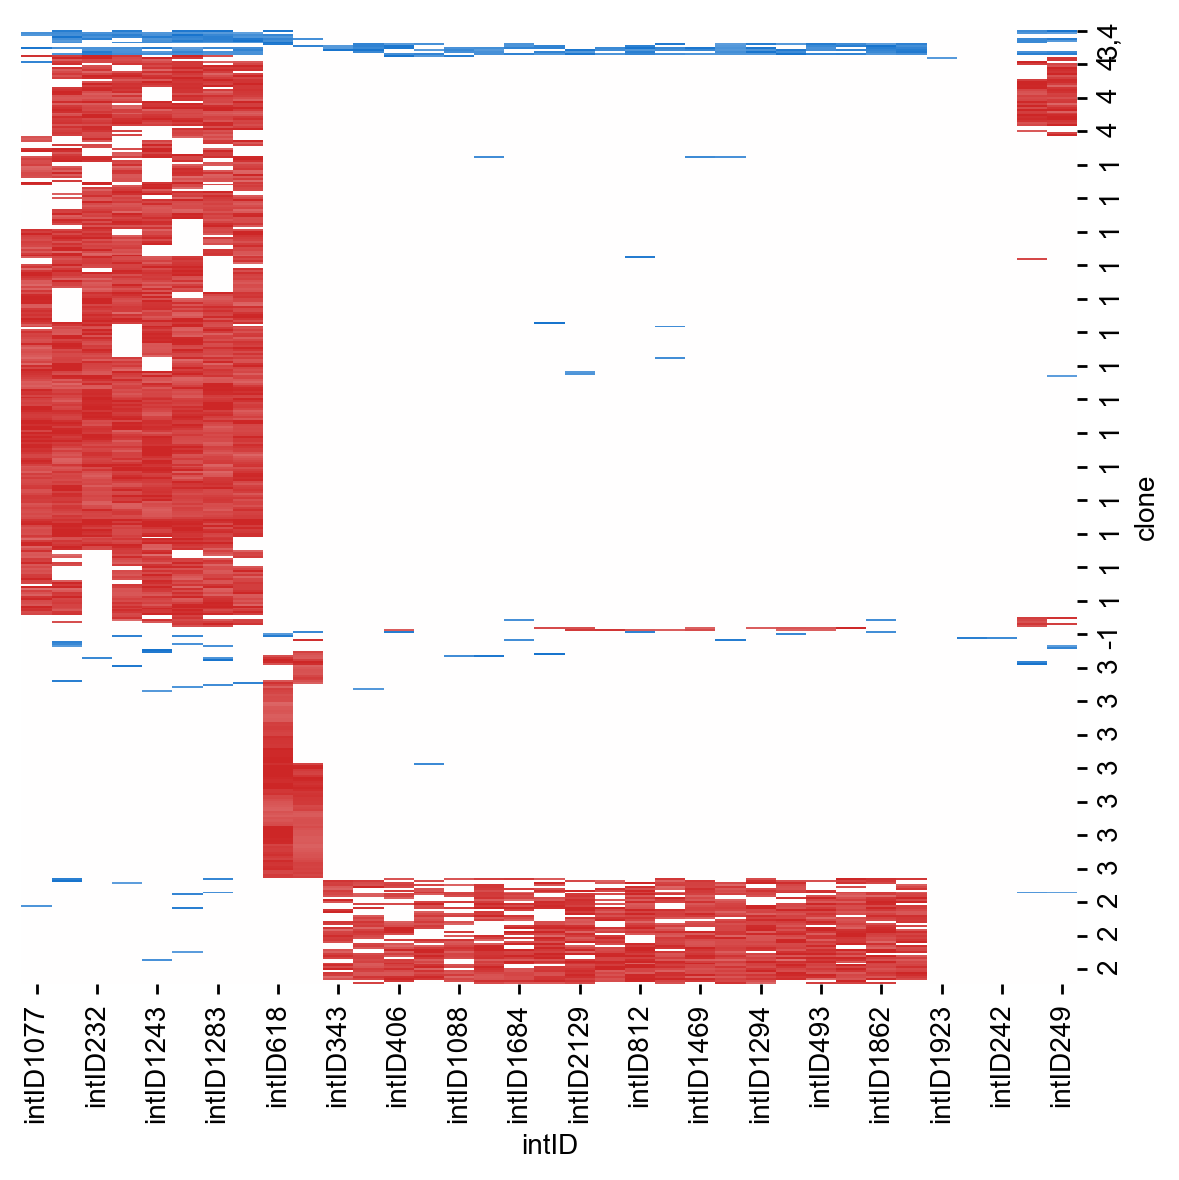

In [13]:
min_jaccard = .2
whitelist_alleles = []
cell_to_clone = []
for sample in alleles["sample"].unique():
    sample_alleles, sample_clones = assign_clones(filtered_alleles, clone_whitelist = clone_whitelist,top_n = 50,
                                doublets=True,plot = True,min_jaccard = min_jaccard)
    whitelist_alleles.append(sample_alleles)
    cell_to_clone.append(sample_clones.assign(sample = sample))
whitelist_alleles = pd.concat(whitelist_alleles)
cell_to_clone = pd.concat(cell_to_clone)

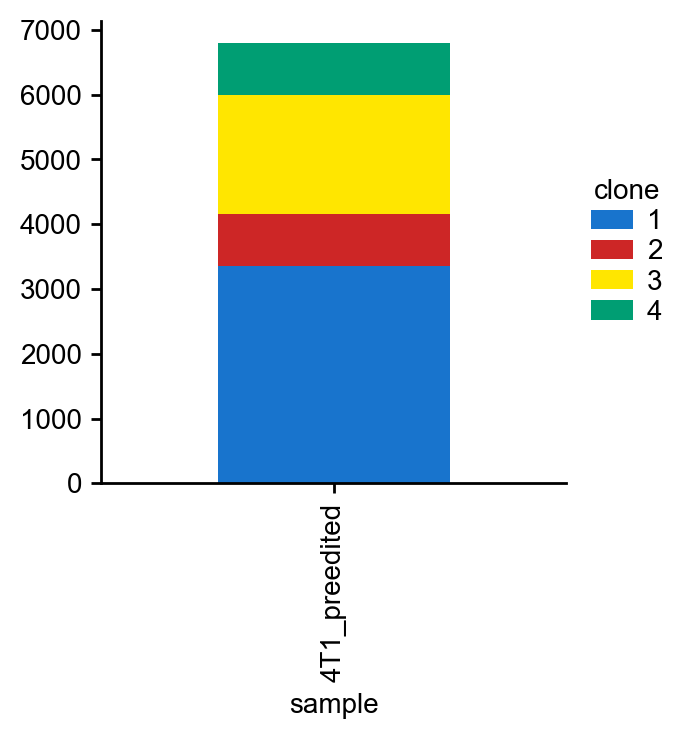

In [14]:
filtered_alleles = whitelist_alleles.copy()
doublets = cell_to_clone.query("clone.str.contains(',')")["cellBC"]
cell_to_clone = cell_to_clone.query("whitelist").copy()
filtered_alleles["clone"] = filtered_alleles["cellBC"].map(cell_to_clone.set_index("cellBC")["clone"])
adata.obs["clone"] = adata.obs["cellBC"].map(cell_to_clone.set_index("cellBC")["clone"])
adata.obs.groupby(['sample', 'clone'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='clone', bbox_to_anchor=(1, 0.5))

Mark doublets and unassigned cells

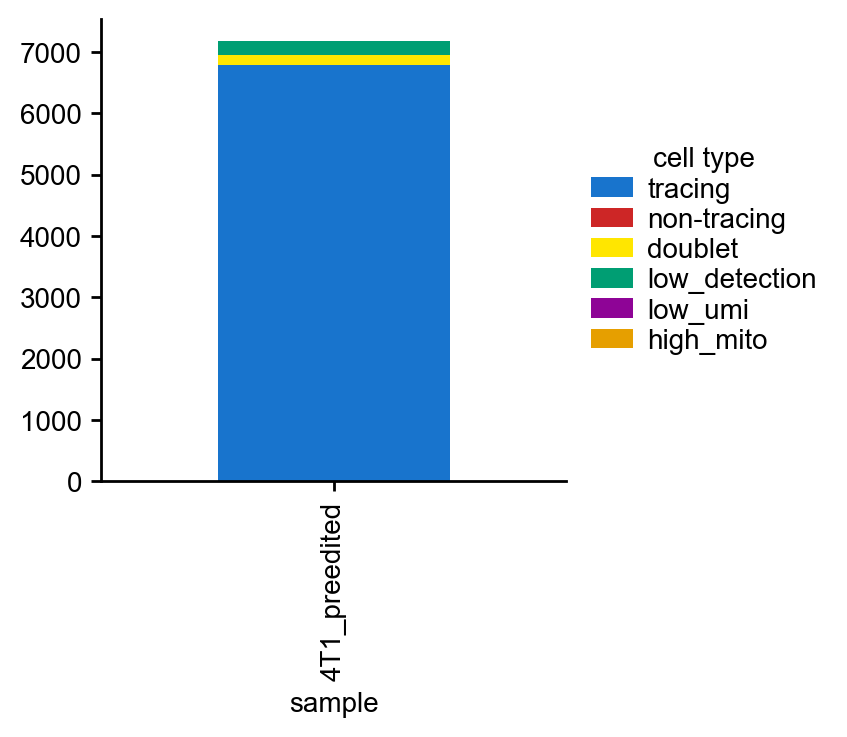

In [15]:
adata.obs.loc[doublets, "type"] = "doublet"
adata.obs.loc[(adata.obs["type"] == "tracing") & adata.obs.clone.isna(), "type"] = "low_detection"
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

Spatial organization of clones

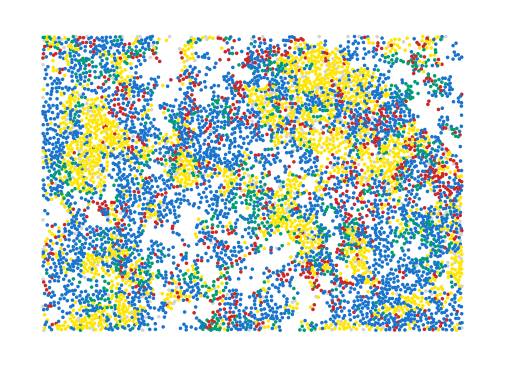

In [16]:
sc.pl.spatial(adata, color = "clone",legend_loc = "none",spot_size=20,legend_fontsize = 6,frameon=False,title = "")

## Decode alleles

Setup

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

Add actual alleles

In [18]:
tracing_cells = adata.obs.query("type == 'tracing'")["cellBC"]
filtered_alleles = filtered_alleles.query("cellBC in @tracing_cells")
filtered_alleles = filtered_alleles.merge(clone_whitelist.drop(columns = "intBC").rename(
            columns = {"EMX1":"EMX1_actual","RNF2":"RNF2_actual","HEK3":"HEK3_actual"}),
            on = ["intID","clone"],how = "left").reset_index(drop = True)

Decode with 5-fold cross validation

In [19]:
whitelist_idx = filtered_alleles.query("whitelist").index
bits = pd.read_csv(data_path / "lineage_merfish_bits.csv",keep_default_na=False)
for site in site_names:
    intensities = filtered_alleles[bits.query("site == @site")["bit"]].values
    intensities = intensities/intensities.sum(axis = 1,keepdims = True)
    site_actual = filtered_alleles[f"{site}_actual"]
    for train_idx, test_idx in KFold(n_splits=5, shuffle=True).split(whitelist_idx):
        train_idx = whitelist_idx[train_idx]
        test_idx = whitelist_idx[test_idx]
        model = LogisticRegression(class_weight = "balanced").fit(intensities[train_idx],site_actual[train_idx])
        filtered_alleles.loc[test_idx,site] = model.predict(intensities[test_idx])
        filtered_alleles.loc[test_idx,f"{site}_prob"] = model.predict_proba(intensities[test_idx,:]).max(axis=1)
        brightest_rounds = np.argmax(intensities[test_idx],axis = 1)
        edits = np.array(list(edit_ids[site].keys())[1:] + ["None"])
        filtered_alleles.loc[test_idx,f"{site}_brightest"] = edits[brightest_rounds]
    print(site,filtered_alleles.query("whitelist").eval(f"{site} == {site}_actual").mean())
    

RNF2 0.9812106905784129
HEK3 0.9702000918870106
EMX1 0.9689009996673057


## Resolve allele conflicts

Select brightest spot within the nucleus for each allele

In [20]:
filtered_alleles["in_nucleus"] = filtered_alleles["cell_dist"] == 0
filtered_alleles = filtered_alleles.sort_values(["in_nucleus","intBC_intensity"],ascending = False).groupby(
    ["cellBC","intID","HEK3","EMX1","RNF2"]).first().reset_index()
filtered_alleles["n_alleles"] = filtered_alleles.groupby(["clone","cellBC","intID"]).intID.transform("count")

Mark cells with conflict in > 50% of alleles as doublets

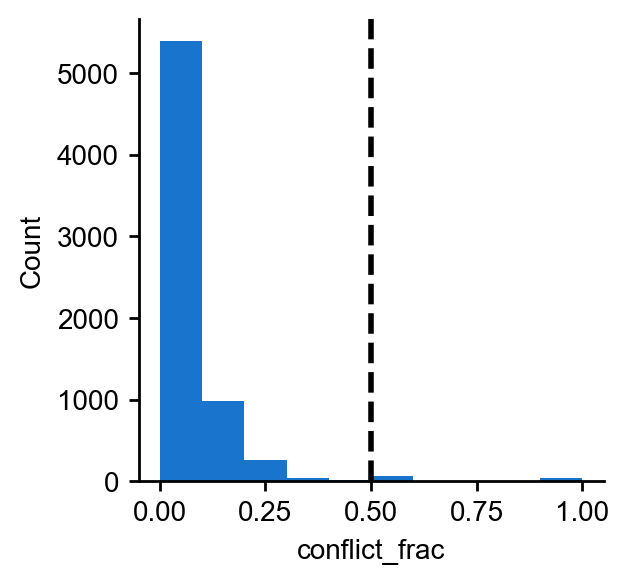

In [21]:
max_cell_conflict = .50
cell_conflicts = filtered_alleles.query("whitelist").groupby(["clone","cellBC","intID"]).agg({"n_alleles":"first"}).reset_index()
cell_conflicts["conflict"] = cell_conflicts["n_alleles"] > 1
cell_conflicts = cell_conflicts.groupby(["clone","cellBC"]).agg({"conflict":"mean"}).reset_index().rename(columns = {"conflict":"conflict_frac"})
doublets = cell_conflicts.query("conflict_frac > @max_cell_conflict")["cellBC"]
sns.histplot(cell_conflicts, x = "conflict_frac",bins = 10,multiple="stack",linewidth=0,alpha = 1)
plt.axvline(x=max_cell_conflict, color="black", linestyle="--")

Resolve remaining conflict by selecting the brightest spot

In [22]:
filtered_alleles = filtered_alleles[~filtered_alleles.cellBC.isin(doublets)].copy()
filtered_alleles = filtered_alleles.sort_values("intBC_intensity",ascending = False).groupby(
    ["intID","cellBC"]).first().reset_index().drop(columns = ["n_alleles","in_nucleus"])

Mark doublets

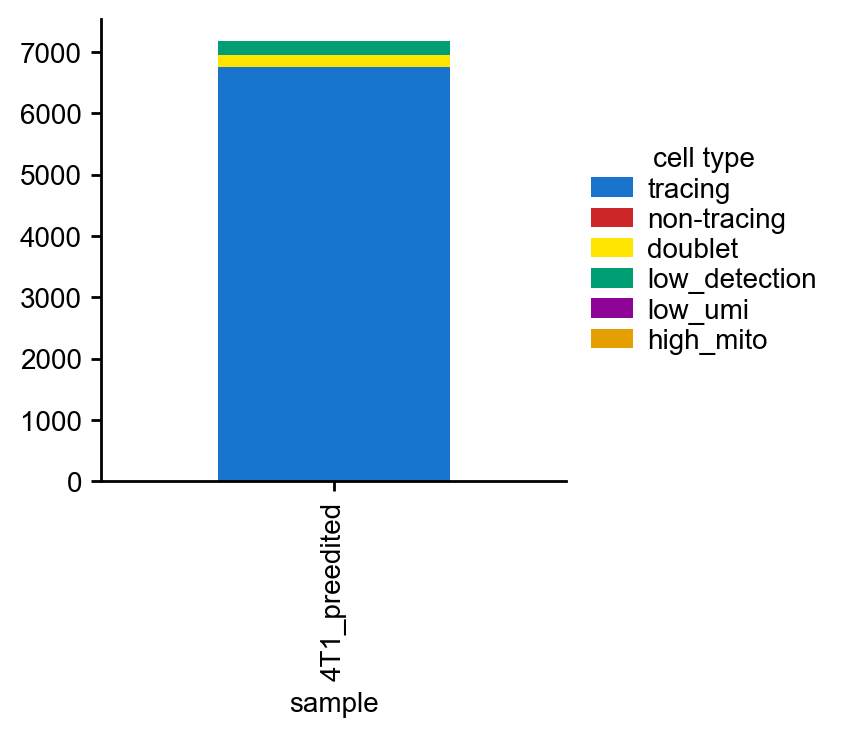

In [23]:
adata.obs.loc[(adata.obs["type"] == "tracing") & (adata.obs.cellBC.isin(doublets)), "type"] = "doublet"
adata.obs.loc[adata.obs["type"] != "tracing", "clone"] = None
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Allele statistics

In [24]:
tracing_cells = adata.obs.query("type == 'tracing'").index
filtered_alleles = filtered_alleles.query("cellBC.isin(@tracing_cells)").copy()

Edit probability vs brightness

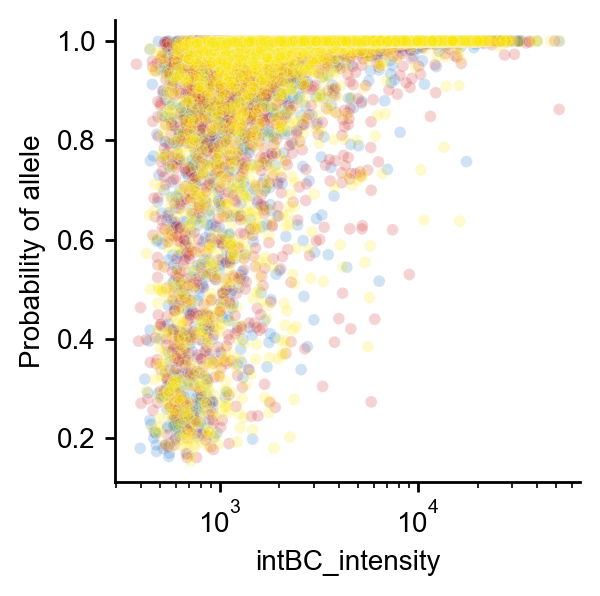

In [25]:
fig, ax = plt.subplots()
for i, site in enumerate(site_names):
    sns.scatterplot(filtered_alleles.sample(5000), x = "intBC_intensity", y = f"{site}_prob",
                    legend=False,alpha = 0.2,size = .1,ax = ax)
plt.xscale("log");
plt.ylabel("Probability of allele");

<Axes: xlabel='clone', ylabel='detection_rate'>

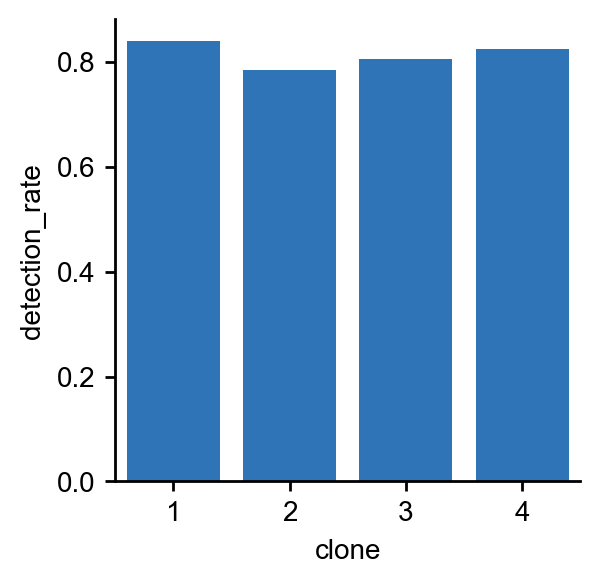

In [26]:
int_detection = (filtered_alleles.query("whitelist").groupby(["intID","clone","sample"]).size() / 
                 filtered_alleles.query("whitelist").groupby(["clone","sample"])["cellBC"].nunique())
int_detection = int_detection.reset_index(name = "detection_rate")
sns.barplot(data = int_detection.groupby(["clone"]).agg({"detection_rate":"mean"}).reset_index(),
            y = "detection_rate",x = "clone")

Detection rate per integration

<Axes: xlabel='clone', ylabel='intID'>

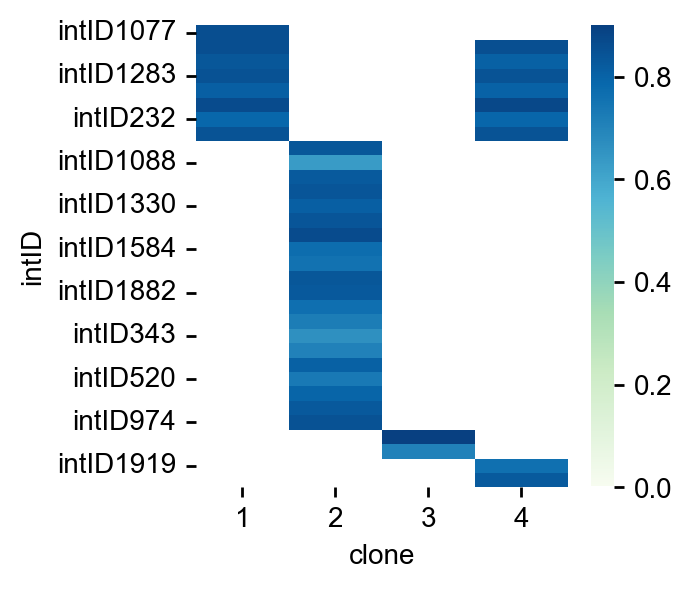

In [27]:
int_order = int_detection.intID.drop_duplicates()
int_detection_wide = pd.pivot_table(int_detection,columns=["clone"], index=["intID"], values="detection_rate")
sns.heatmap(int_detection_wide.loc[int_order,:],cmap = sequential_cmap,vmin = 0)

Detection rate per cell

<Axes: xlabel='detection_rate', ylabel='Count'>

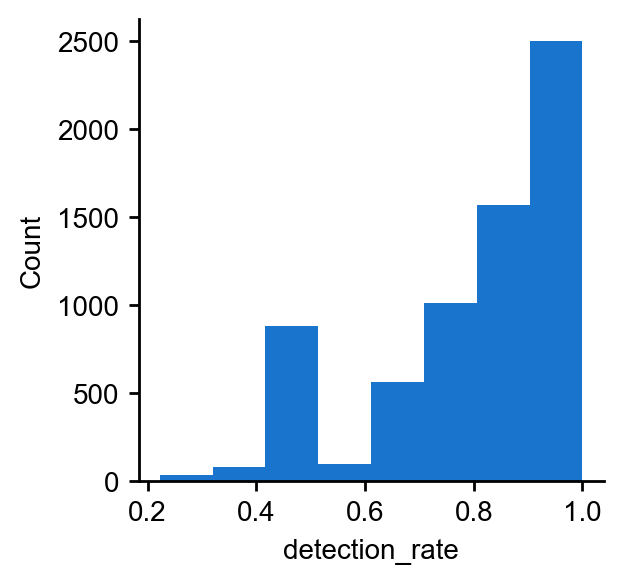

In [28]:
cell_detection = (filtered_alleles.query("whitelist").groupby(["clone","sample","cellBC"]).size() / 
                 filtered_alleles.query("whitelist").groupby(["clone","sample"])["intID"].nunique()).reset_index(name = "detection_rate")
adata.obs["detection_rate"] = adata.obs["cellBC"].map(cell_detection.set_index("cellBC")["detection_rate"])
sns.histplot(cell_detection, x = "detection_rate",bins = 8,linewidth=0,alpha = 1)

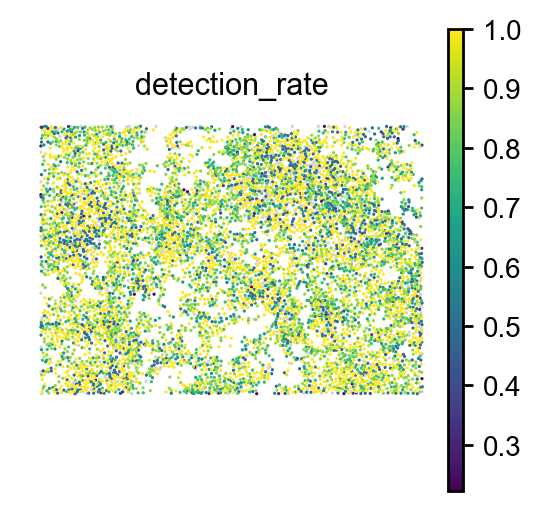

In [29]:
sc.pl.spatial(adata, color = "detection_rate", spot_size = 20,frameon=False)

Edit fraction

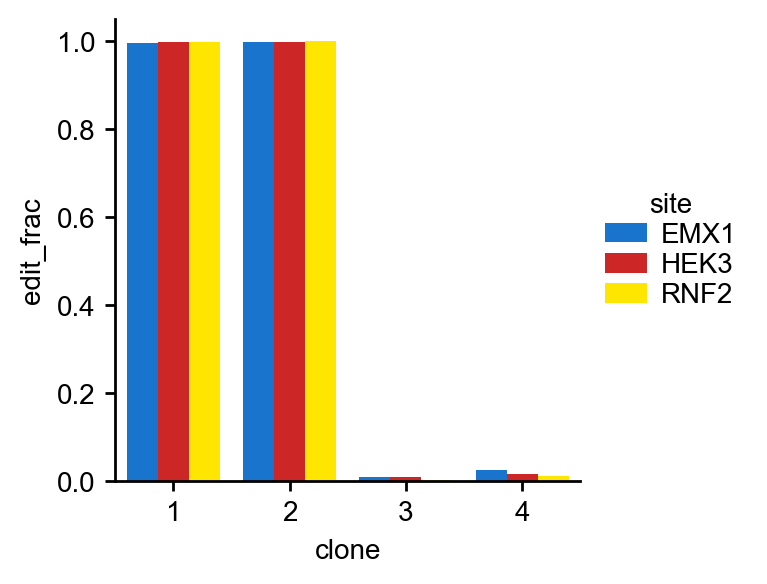

In [30]:
edit_counts = filtered_alleles.query("whitelist")[site_names + ["cellBC","intID","clone","sample"]].melt(
    id_vars = ["cellBC","intID","clone","sample"],value_name="edit", var_name="site")
edit_frac = edit_counts.query("edit != 'None'").groupby(["clone","sample","intID","site"]).size()/ \
    edit_counts.groupby(["clone","sample","intID","site"]).size()
edit_frac = edit_frac.reset_index(name = "edit_frac").groupby(["clone","site"]).agg({"edit_frac":"mean"}).reset_index()
sns.barplot(data = edit_frac,y = "edit_frac",x = "clone",hue = "site",saturation=1)
plt.legend(loc='center left', title='site', bbox_to_anchor=(1, 0.5))

Edit frequency

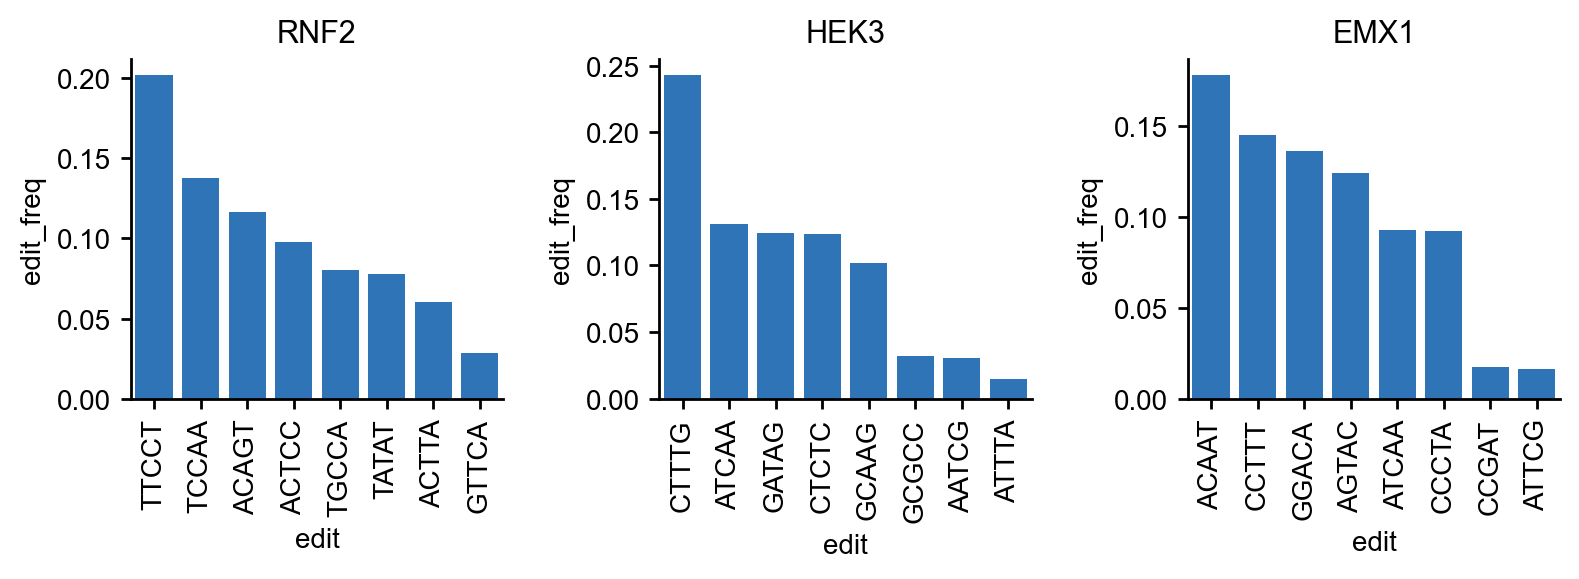

In [31]:
edit_frequency =  edit_counts.groupby(["site","edit"]).size() / edit_counts.groupby(["site"]).size()
edit_frequency = edit_frequency.reset_index(name = "edit_freq")

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for i, site in enumerate(site_names):
    sns.barplot(
        data=edit_frequency.query(f"site == '{site}' & edit != 'None'").sort_values("edit_freq", ascending=False).head(15),
        x="edit",y="edit_freq", ax=axes[i])
    axes[i].set_title(site)
    plt.setp(axes[i].get_xticklabels(), rotation=90)

plt.tight_layout()

## Write data

In [36]:
name = "merfish_invitro"
adata.obs.to_file(data_path / f"{name}_cells.json", driver='GeoJSON')
filtered_alleles.drop(columns = 
    ["RNF2_actual","HEK3_actual","EMX1_actual"] + bits.bit.tolist(),
     errors="ignore").to_csv(data_path / f"{name}_alleles.csv",index = False)

/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
